# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import sys
import tensorflow as tf

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

C:\Users\sanyam.agarwal\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Env setup

In [2]:
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

In [4]:

CKPT = 'graph/faster_rcnn_resnet101_coco_2018_01_28/frozen_inference_graph.pb'
PATH_TO_LABELS = 'data/label_map.pbtxt'

NUM_CLASSES = 4

## Load a (frozen) Tensorflow model into memory.

In [5]:
detection_graph = tf.Graph()

with detection_graph.as_default():
    
  od_graph_def = tf.GraphDef()

  with tf.gfile.GFile(CKPT, 'rb') as fid:
        
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [6]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': 'Green'}, 2: {'id': 2, 'name': 'Red'}, 3: {'id': 3, 'name': 'Yellow'}, 4: {'id': 4, 'name': 'off'}}


## Helper code

In [7]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [8]:
from glob import glob

In [10]:

PATH_TO_TEST_IMAGES_DIR = 'test_images_bosch'

print(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.png'))
TEST_IMAGE_PATHS = glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.png'))
print("Length of test images:", len(TEST_IMAGE_PATHS))

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

test_images_bosch\*.png
Length of test images: 7


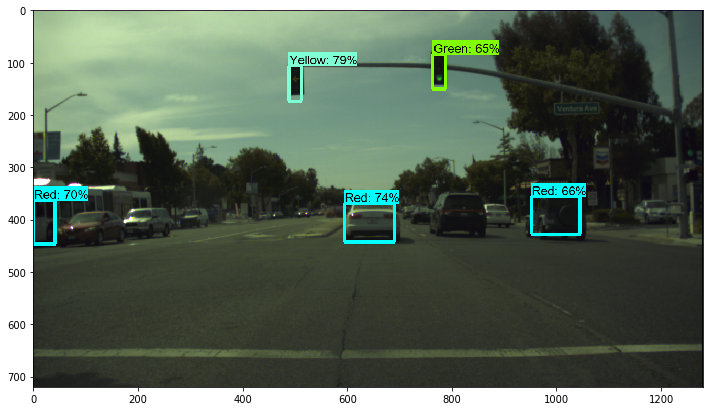

Yellow 0.79274505
Distance (metres) 8.0
Time in milliseconds 21705.44958114624 

Red 0.7449972
Distance (metres) 4.0
Time in milliseconds 21705.44958114624 

Red 0.7066423
Distance (metres) 5.0
Time in milliseconds 21705.44958114624 

Red 0.66774875
Distance (metres) 5.0
Time in milliseconds 21705.44958114624 

Green 0.65066767
Distance (metres) 8.0
Time in milliseconds 21705.44958114624 



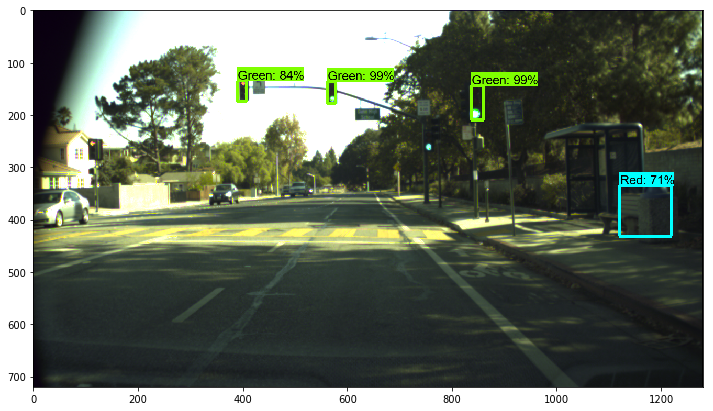

Green 0.99642915
Distance (metres) 8.0
Time in milliseconds 17939.4314289093 

Green 0.99065244
Distance (metres) 12.0
Time in milliseconds 17939.4314289093 

Green 0.8449795
Distance (metres) 12.0
Time in milliseconds 17939.4314289093 

Red 0.714338
Distance (metres) 4.0
Time in milliseconds 17939.4314289093 



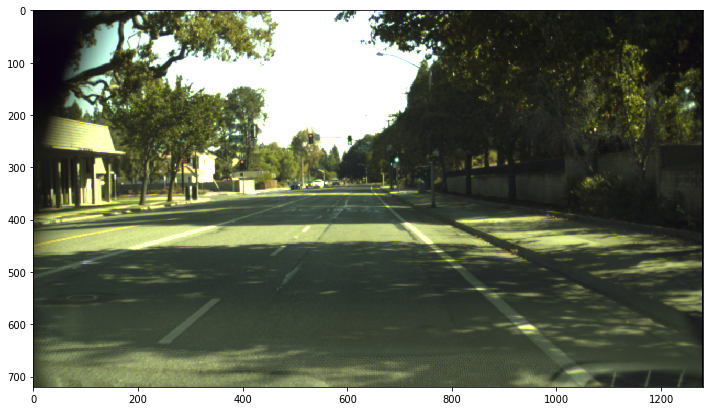

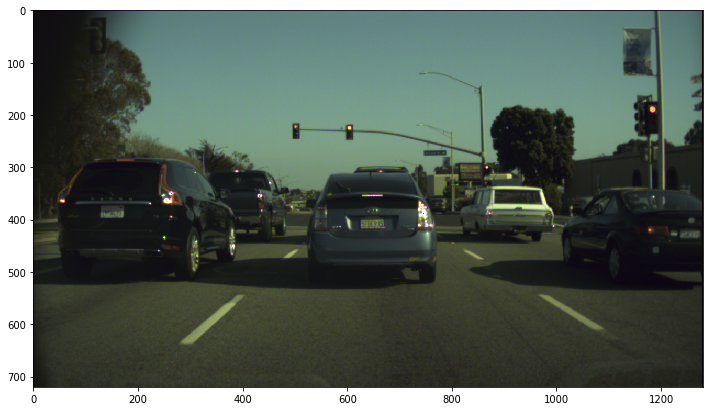

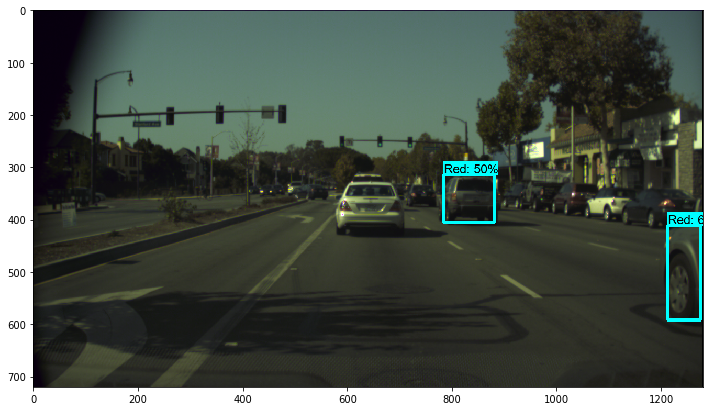

Red 0.6263329
Distance (metres) 3.0
Time in milliseconds 17064.340591430664 

Red 0.5071314
Distance (metres) 4.0
Time in milliseconds 17064.340591430664 



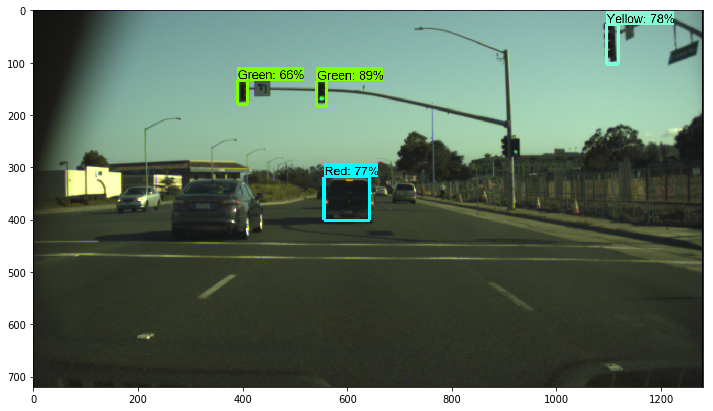

Green 0.8983723
Distance (metres) 10.0
Time in milliseconds 17048.713207244873 

Yellow 0.7855037
Distance (metres) 8.0
Time in milliseconds 17048.713207244873 

Red 0.77871925
Distance (metres) 4.0
Time in milliseconds 17048.713207244873 

Green 0.66950256
Distance (metres) 11.0
Time in milliseconds 17048.713207244873 



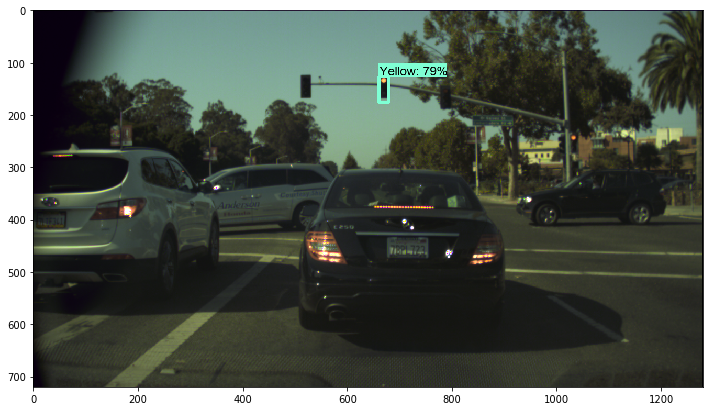

Yellow 0.796887
Distance (metres) 11.0
Time in milliseconds 19111.42921447754 



In [11]:
import time

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)

            time0 = time.time()

            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})

            time1 = time.time()

            boxes = np.squeeze(boxes)
            scores = np.squeeze(scores)
            classes = np.squeeze(classes).astype(np.int32)
            
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, boxes, classes, scores,
                category_index,
                use_normalized_coordinates=True,
                line_thickness=6)
            
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()

            min_score_thresh = .50
            for i in range(boxes.shape[0]):
                if scores is None or scores[i] > min_score_thresh:

                    class_name = category_index[classes[i]]['name']
                    print('{}'.format(class_name), scores[i])
                    
                    fx =  1345.200806
                    fy =  1353.838257
                    perceived_width_x = (boxes[i][3] - boxes[i][1]) * 800
                    perceived_width_y = (boxes[i][2] - boxes[i][0]) * 600

                    # ymin, xmin, ymax, xmax = box
                    # depth_prime = (width_real * focal) / perceived_width
                    perceived_depth_x = ((.1 * fx) / perceived_width_x)
                    perceived_depth_y = ((.3 * fy) / perceived_width_y )

                    estimated_distance = round((perceived_depth_x + perceived_depth_y) / 2)
                    print("Distance (metres)", estimated_distance)
                    print("Time in milliseconds", (time1 - time0) * 1000, "\n") 

            